# **Nama : 2209106021**
# **NIM  : Bimasakti Cahyo Utomo**

Dataset : [Wonders of The World (Kaggle)](https://www.kaggle.com/datasets/balabaskar/wonders-of-the-world-image-classification)

Dataset ini berisi gambar Keajaiban dunia (Wonders of The World) yang berjumlah
12 kelas


### Untuk Google Colab

In [99]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/balabaskar/wonders-of-the-world-image-classification")

Skipping, found downloaded files in "./wonders-of-the-world-image-classification" (use force=True to force download)


## **Import Library**

In [100]:
import os
import shutil
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

## **Ekstraksi Fitur HOG**
Penggunaan HOG untuk deteksi pola visual pada bangunan adalah teknik yang sangat efektif untuk mengidentifikasi dan mengenali objek atau fitur penting pada citra bangunan. HOG adalah metode ekstraksi fitur yang memanfaatkan informasi tentang arah gradien dalam citra untuk menggambarkan bentuk dan struktur objek.

Gambar diubah ke grayscale kemudian dialkuakl ekstraksi fitur.Ukuran gambar dinormalisasi ke 128x128px agar ternormalisasi.

In [101]:
def extract_hog_features(image):
    image = cv2.resize(image, (128, 128))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features, _ = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), block_norm='L2-Hys',
                      visualize=True)
    return features

## **Load dataset dan label**
Dataset diload per folder kelas

In [102]:
def load_dataset_and_labels(folder_path):
    features, labels = [], []
    for label_name in os.listdir(folder_path):
        class_dir = os.path.join(folder_path, label_name)
        if not os.path.isdir(class_dir):
            continue
        for fname in os.listdir(class_dir):
            fpath = os.path.join(class_dir, fname)
            image = cv2.imread(fpath)
            if image is None:
                continue
            image = cv2.resize(image, (128, 128))
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            hog_feature = hog(gray,
                              orientations=9,
                              pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2),
                              block_norm='L2-Hys',
                              visualize=False)
            features.append(hog_feature)
            labels.append(label_name)
    return np.array(features), np.array(labels)

In [103]:
X, y = load_dataset_and_labels("Wonders of World")
le = LabelEncoder()
y_encoded = le.fit_transform(y)

## **Standarisasi Fitur**

Standarisasi fitur digunakan untuk memastikan bahwa setiap fitur dalam dataset memiliki skala yang seragam. Ini sangat penting karena SVM adalah algoritma yang sangat sensitif terhadap skala fitur, dan tanpa standarisasi, fitur dengan rentang nilai yang lebih besar bisa mendominasi keputusan model, mengurangi akurasi dan performa secara keseluruhan.

In [104]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## **Train-test split**

 Digunakan untuk membagi dataset menjadi dua set: satu untuk melatih model dan satu untuk mengujinya.

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

## **Train SVM**

Kernel linear digunakan karena pas saya pake yang lain akurasi jadi makin jelek.

In [112]:
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

SVC(kernel='linear')

## **Evaluasi Akurasi dan Confusion Matrix**

Melihat akurasi hasil akurasi model serta menggunakan Confusion Matrix untuk melihat benar salah model pada setiap kelas yang terdapat pada dataset


In [113]:
accuracy = svm.score(X_test, y_test)
print(f"SVM Accuracy: {accuracy:.2f}")

SVM Accuracy: 0.75


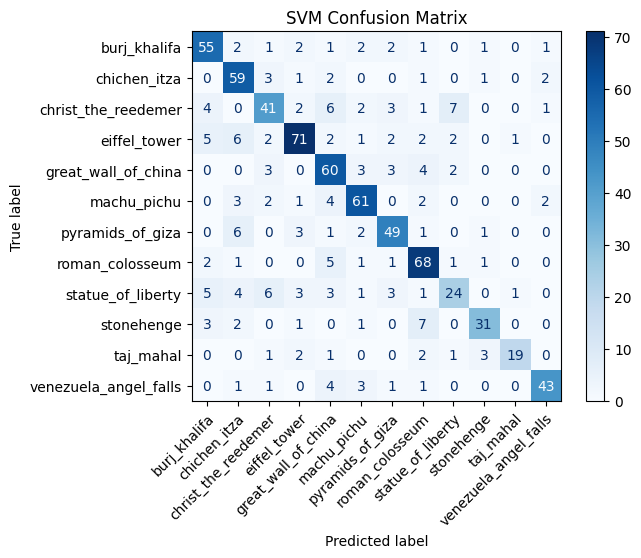

In [114]:
y_pred_svm = svm.predict(X_test)

cm = confusion_matrix(y_test, y_pred_svm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.title("SVM Confusion Matrix")
plt.show()


## **Clasification Report**
#### **Memberikan metrik klasifikasi:**

*   Precision: Akurasi prediksi positif.
*   Recall: Seberapa baik model mendeteksi semua positif.
*   F1-score: Rata-rata harmonik precision dan recall



In [115]:
print("Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

Classification Report:
                       precision    recall  f1-score   support

         burj_khalifa       0.74      0.81      0.77        68
         chichen_itza       0.70      0.86      0.77        69
  christ_the_reedemer       0.68      0.61      0.65        67
         eiffel_tower       0.83      0.76      0.79        94
  great_wall_of_china       0.67      0.80      0.73        75
          machu_pichu       0.79      0.81      0.80        75
     pyramids_of_giza       0.77      0.78      0.77        63
      roman_colosseum       0.75      0.85      0.80        80
    statue_of_liberty       0.65      0.47      0.55        51
           stonehenge       0.82      0.69      0.75        45
            taj_mahal       0.90      0.66      0.76        29
venezuela_angel_falls       0.88      0.80      0.83        54

             accuracy                           0.75       770
            macro avg       0.77      0.74      0.75       770
         weighted avg       0.

## **Test Model** + **Membuat folder test**

Digunakan untuk memvisualisasikan performa model dengan menampilkan prediksi dan label asli. Jika prediksi benar maka berwarna hijau jika salah maka berwarna merah.

In [116]:
original_dataset_dir = 'Wonders of World'
test_dir = 'test'

os.makedirs(test_dir, exist_ok=True)

test_ratio = 0.2

for class_name in os.listdir(original_dataset_dir):
    class_dir = os.path.join(original_dataset_dir, class_name)
    if not os.path.isdir(class_dir):
        continue

    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    images = os.listdir(class_dir)
    random.shuffle(images)
    split_index = int(len(images) * test_ratio)

    test_images = images[:split_index]

    for img in test_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(test_dir, class_name, img)
        shutil.copy2(src, dst)

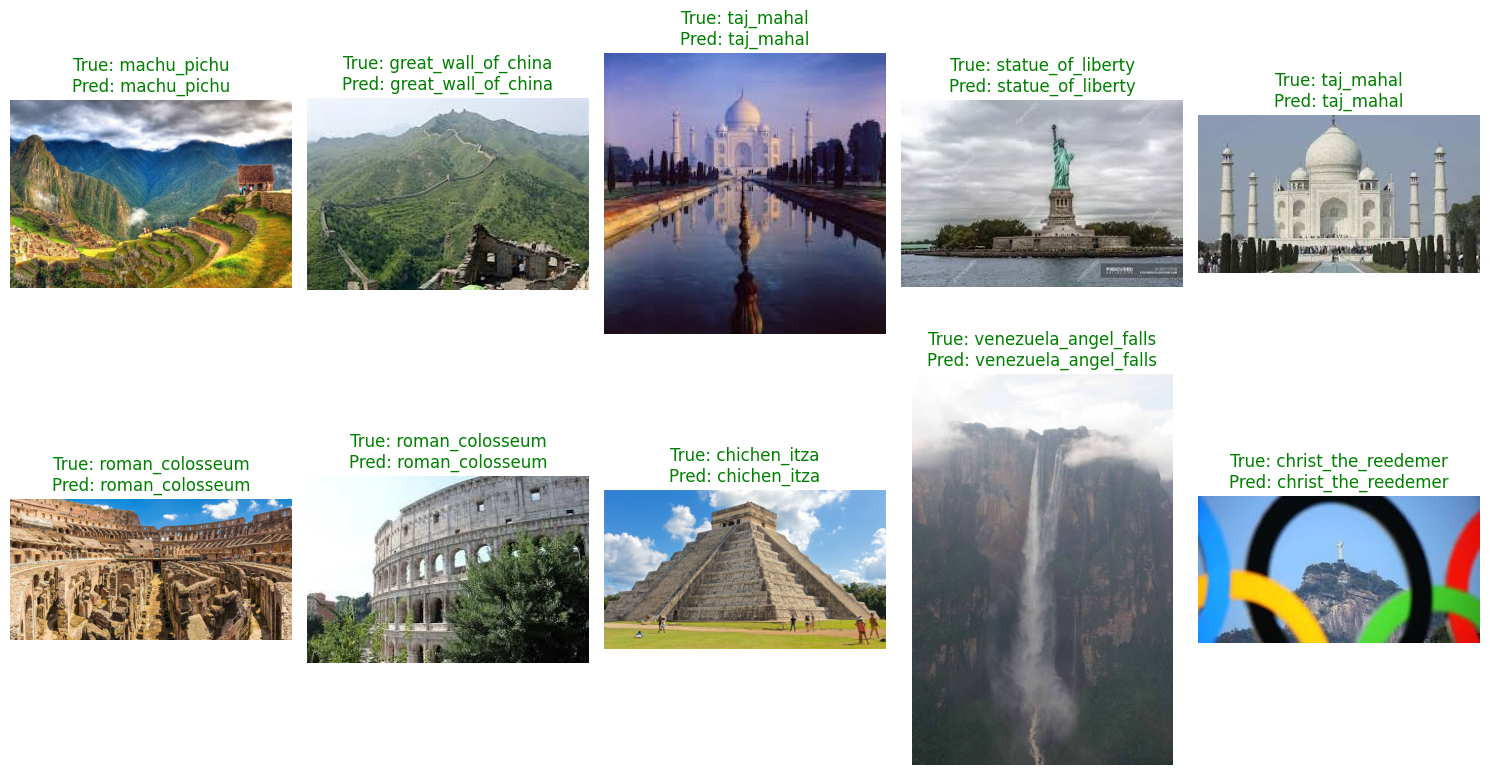

In [117]:
def visualize_sample_predictions(model, folder_path, label_encoder, scaler, num_samples=10):
    image_paths = []
    labels = []

    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(img_path)
                labels.append(class_name)

    if num_samples > len(image_paths):
        num_samples = len(image_paths)
        print(f"Hanya {num_samples} gambar yang tersedia, menyesuaikan jumlah sampel.")

    indices = np.random.choice(len(image_paths), num_samples, replace=False)

    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(indices):
        img_path = image_paths[idx]
        true_label = labels[idx]

        image = cv2.imread(img_path)
        if image is None:
            print(f"Gagal membaca gambar: {img_path}")
            continue

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        feature = extract_hog_features(image)
        feature = scaler.transform([feature])
        pred = model.predict(feature)[0]
        pred_label = label_encoder.inverse_transform([pred])[0]

        plt.subplot(2, 5, i + 1)
        plt.imshow(image_rgb)
        plt.title(f"True: {true_label}\nPred: {pred_label}",
                  color='green' if true_label == pred_label else 'red')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_sample_predictions(svm, test_dir, le, scaler, num_samples=10)